<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/model_ds_magnitude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy.optimize import curve_fit
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from astropy import units as u
from astropy.io import fits

In [0]:
#GAIA passbands
gaia_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/GAIADR2/GaiaDR2_RevisedPassbands.dat'
gaia = np.loadtxt(gaia_data)
gaia = np.where(gaia==99.99,0,gaia)
gaia_w = gaia[:,0]*10 #Angstrom
gaia_g = gaia[:,1]
gaia_bp = gaia[:,3]
gaia_rp = gaia[:,5]

def inter_g(wavelength): 
  f = interp1d(gaia_w,gaia_g)
  return f(wavelength)
  
def inter_gbp(wavelength): 
  f = interp1d(gaia_w,gaia_bp)
  return f(wavelength)
  
def inter_grp(wavelength): 
  f = interp1d(gaia_w,gaia_rp)
  return f(wavelength)

#WISE passbands
wise1_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W1.txt'
wise2_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W2.txt'
wise3_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W3.txt'
wise4_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W4.txt'

w1 = np.loadtxt(wise1_data)
w2 = np.loadtxt(wise2_data)
w3 = np.loadtxt(wise3_data)
w4 = np.loadtxt(wise4_data)

w1ww = w1[:,0]*1e4
w1r = w1[:,1]

w2ww = w2[:,0]*1e4
w2r = w2[:,1]

w3ww = w3[:,0]*1e4
w3r = w3[:,1]

w4ww = w4[:,0]*1e4
w4r = w4[:,1]

#wavelength must be between 25300 and 65000 A (W1)
#wavelength must be between 25300 and 80000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)


def inter_w1(wavelength): 
  f = interp1d(w1ww,w1r)
  return f(wavelength)
  
def inter_w2(wavelength): 
  f = interp1d(w2ww,w2r)
  return f(wavelength)

def inter_w3(wavelength): 
  f = interp1d(w3ww,w3r)
  return f(wavelength)

def inter_w4(wavelength): 
  f = interp1d(w4ww,w4r)
  return f(wavelength)


def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,65100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,65000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620
 
def BB_G(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(2900,11100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(3000,11000,1)
  f = np.trapz(fgaia(ww) * inter_g(ww) * ww, x=ww) / np.trapz(inter_g(ww) * cA / ww, x=ww)
  g =  -2.5 * np.log10(f) - 48.60
  return g - 25.7915509947 + 25.6914396869

In [0]:
#Model for T=600
luminosity = np.arange(0.001,100,0.01)
GG = []
WW4 = []
WW3 = []
for l in luminosity:
  GG.append(BB_G(600,l))
  WW3.append(BB_W3(600,l))
  WW4.append(BB_W4(600,l))

In [27]:
def eqn(data,a,b,c,d,e):#,k,l,m,n,o):
    x = data
    return a*x**3 + b*x**2 + c*x + d*x**4 + e
    
popt1,pcov1 = curve_fit(eqn,np.log10(luminosity),np.log10(GG),p0=[1,1,1,1,1])
print(popt1,pcov1)

popt2,pcov2 = curve_fit(eqn,np.log10(luminosity),np.log10(np.array(WW3)+50),p0=[1,1,1,1,1])
print(popt2,pcov2)

popt3,pcov3 = curve_fit(eqn,np.log10(luminosity),np.log10(np.array(WW4)+50),p0=[1,1,1,1,1])
print(popt3,pcov3)

[-2.41939823e-05 -6.52916717e-04 -2.38197555e-02 -1.01120707e-06
  1.65878364e+00] [[ 6.96080490e-19  5.21236652e-20 -1.60320276e-18 -2.09806418e-19
   8.94628977e-19]
 [ 5.21236652e-20  9.27022837e-18 -8.77913411e-18 -1.29726810e-18
  -4.86409059e-19]
 [-1.60320276e-18 -8.77913411e-18  1.48853017e-17  1.45072924e-18
  -4.53889870e-18]
 [-2.09806418e-19 -1.29726810e-18  1.45072924e-18  2.64806513e-19
  -2.95383633e-20]
 [ 8.94628977e-19 -4.86409059e-19 -4.53889870e-18 -2.95383633e-20
   4.72578105e-18]]
[-2.20564619e-05 -6.14206009e-04 -2.31023587e-02 -8.93567103e-07
  1.67206500e+00] [[ 5.11180360e-19  3.78482679e-20 -1.17707615e-18 -1.54001391e-19
   6.57113427e-19]
 [ 3.78482679e-20  6.80796171e-18 -6.44695957e-18 -9.52508702e-19
  -3.57293921e-19]
 [-1.17707615e-18 -6.44695957e-18  1.09317072e-17  1.06516102e-18
  -3.33386592e-18]
 [-1.54001391e-19 -9.52508702e-19  1.06516102e-18  1.94409450e-19
  -2.16916076e-20]
 [ 6.57113427e-19 -3.57293921e-19 -3.33386592e-18 -2.16916076e-20
  

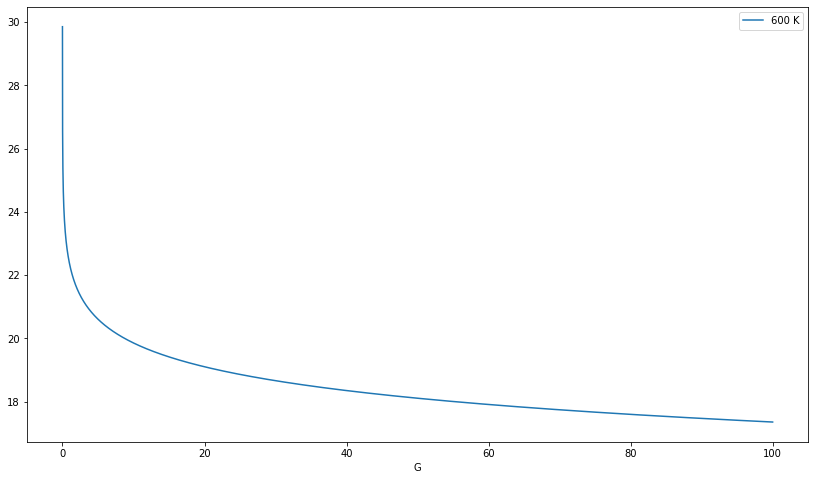

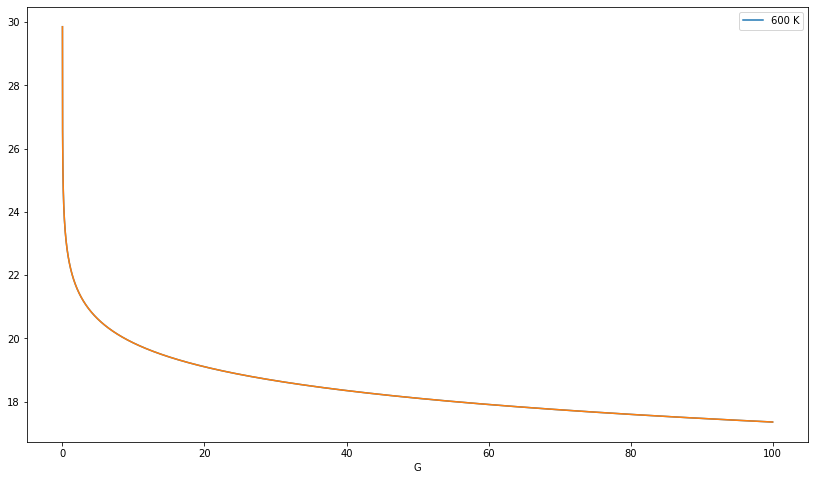

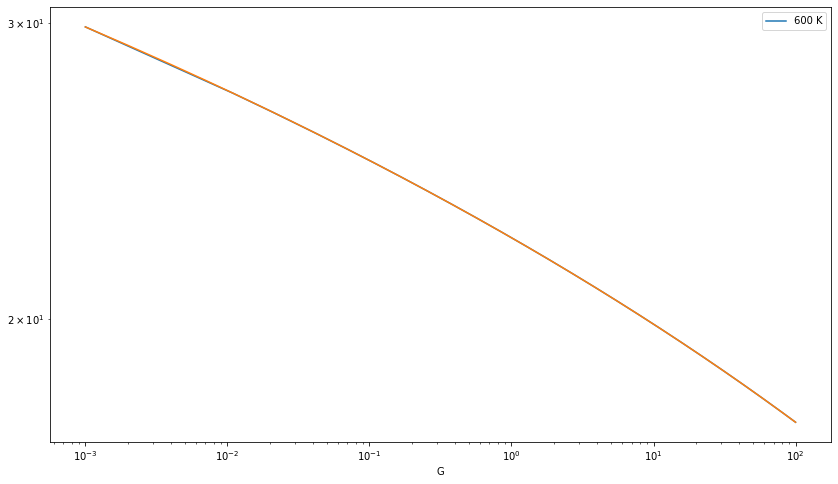

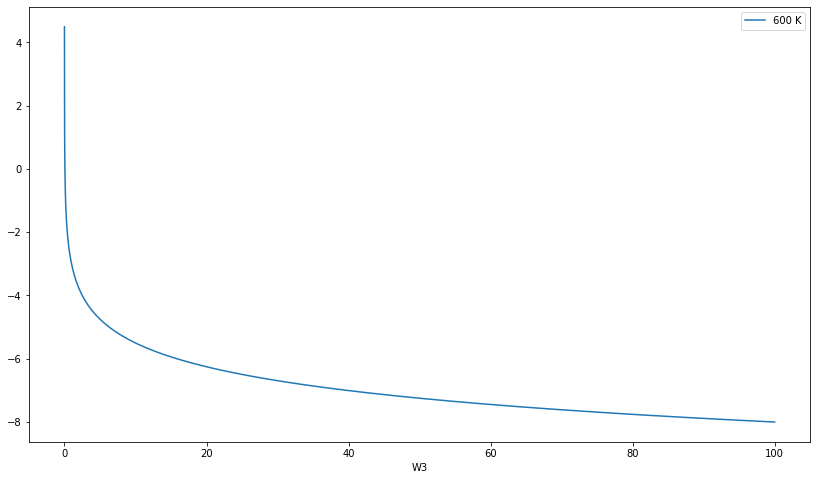

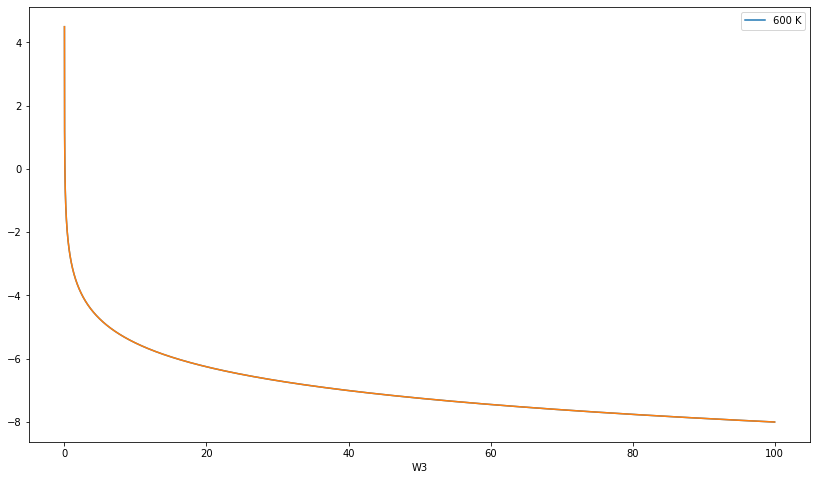

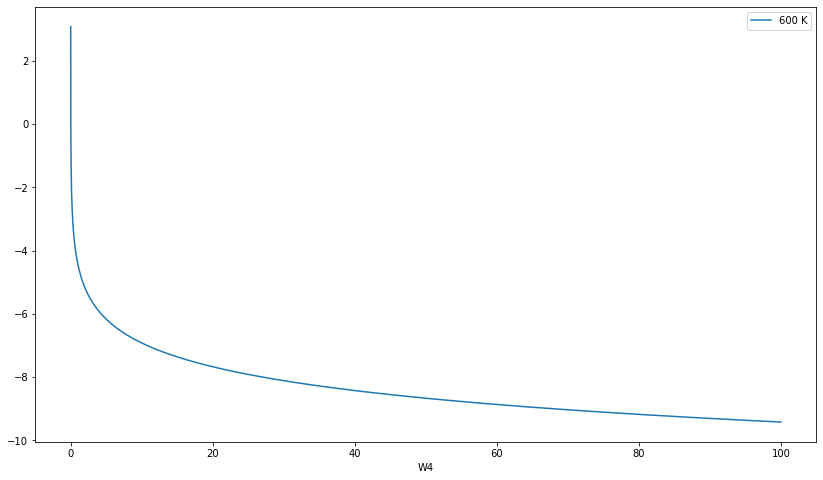

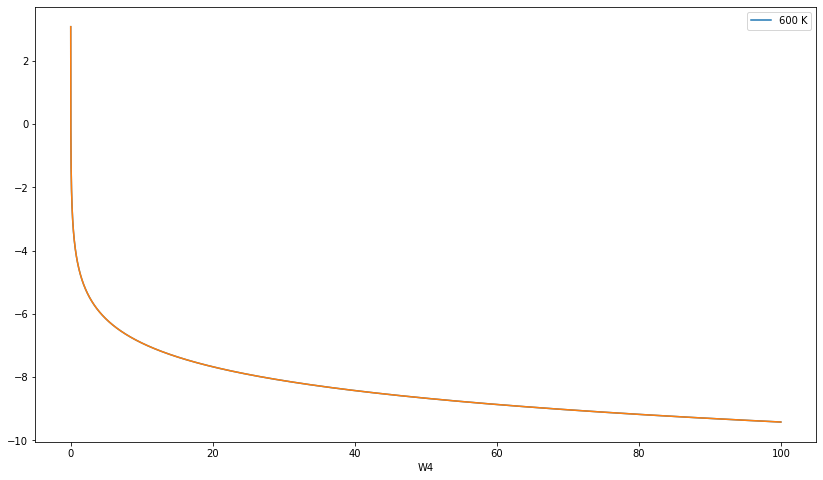

In [28]:
x = np.arange(0.001,100,0.001)

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt1[0],popt1[1],popt1[2],popt1[3],popt1[4])))
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt1[0],popt1[1],popt1[2],popt1[3],popt1[4])))
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW3,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'W3')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW3,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt2[0],popt2[1],popt2[2],popt2[3],popt2[4]))-50)
plt.xlabel(r'Lbol')
plt.xlabel(r'W3')
plt.legend()
plt.show()


plt.figure(figsize=(14,8))
plt.plot(luminosity,WW4,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'W4')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW4,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt3[0],popt3[1],popt3[2],popt3[3],popt3[4]))-50)
plt.xlabel(r'Lbol')
plt.xlabel(r'W4')
plt.legend()
plt.show()


#[-2.41939823e-05 -6.52916717e-04 -2.38197555e-02 -1.01120707e-06 1.65878364e+00]
#[-2.20564619e-05 -6.14206009e-04 -2.31023587e-02 -8.93567103e-07 1.67206500e+00]
#[-2.41939823e-05 -6.52916717e-04 -2.38197555e-02 -1.01120707e-06 1.65878364e+00] 

# T = 600
# x = np.log10(luminosity)
# g = np.log10(G)
# g(x) = -2.10765326e-04*x**3 + -2.70349708e-03*x**2 + -4.85683779e-02*x + -1.96879505e-05*x**4 + 1.34934221e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.20564619e-05*x**3 + -6.14206009e-04*x**2 + -2.31023587e-02*x + -8.93567103e-07*x**4 +   1.67206500e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.41939823e-05*x**3 + -6.52916717e-04*x**2 + -2.38197555e-02*x + -1.01120707e-06*x**4 + 1.65878364e+00

In [0]:
#Model for T=300
luminosity = np.arange(0.001,100,0.01)
GG = []
WW4 = []
WW3 = []
for l in luminosity:
  GG.append(BB_G(300,l))
  WW3.append(BB_W3(300,l))
  WW4.append(BB_W4(300,l))

In [36]:
def eqn(data,a,b,c,d,e):#,k,l,m,n,o):
    x = data
    return a*x**3 + b*x**2 + c*x + d*x**4 + e
    
popt1,pcov1 = curve_fit(eqn,np.log10(luminosity),np.log10(GG),p0=[1,1,1,1,1])
print(popt1,pcov1)

popt2,pcov2 = curve_fit(eqn,np.log10(luminosity),np.log10(np.array(WW3)+50),p0=[1,1,1,1,1])
print(popt2,pcov2)

popt3,pcov3 = curve_fit(eqn,np.log10(luminosity),np.log10(np.array(WW4)+50),p0=[1,1,1,1,1])
print(popt3,pcov3)

[-2.49649566e-05 -6.66586021e-04 -2.40679889e-02 -1.05452859e-06
  1.65428099e+00] [[ 7.72832522e-19  5.78472201e-20 -1.78002091e-18 -2.32932842e-19
   9.93326624e-19]
 [ 5.78472201e-20  1.02945265e-17 -9.74919852e-18 -1.44060837e-18
  -5.40056492e-19]
 [-1.78002091e-18 -9.74919852e-18  1.65289201e-17  1.61098325e-18
  -5.03962039e-18]
 [-2.32932842e-19 -1.44060837e-18  1.61098325e-18  2.94045469e-19
  -3.28001845e-20]
 [ 9.93326624e-19 -5.40056492e-19 -5.03962039e-18 -3.28001845e-20
   5.24709183e-18]]
[-2.29440595e-05 -6.30431088e-04 -2.34057136e-02 -9.41970700e-07
  1.66639928e+00] [[ 5.83069507e-19  4.32010931e-20 -1.34258670e-18 -1.75670991e-19
   7.49485102e-19]
 [ 4.32010931e-20  7.76630955e-18 -7.35411288e-18 -1.08665943e-18
  -4.07851766e-19]
 [-1.34258670e-18 -7.35411288e-18  1.24691286e-17  1.21507268e-18
  -3.80243041e-18]
 [-1.75670991e-19 -1.08665943e-18  1.21507268e-18  2.21793404e-19
  -2.46799574e-20]
 [ 7.49485102e-19 -4.07851766e-19 -3.80243041e-18 -2.46799574e-20
  

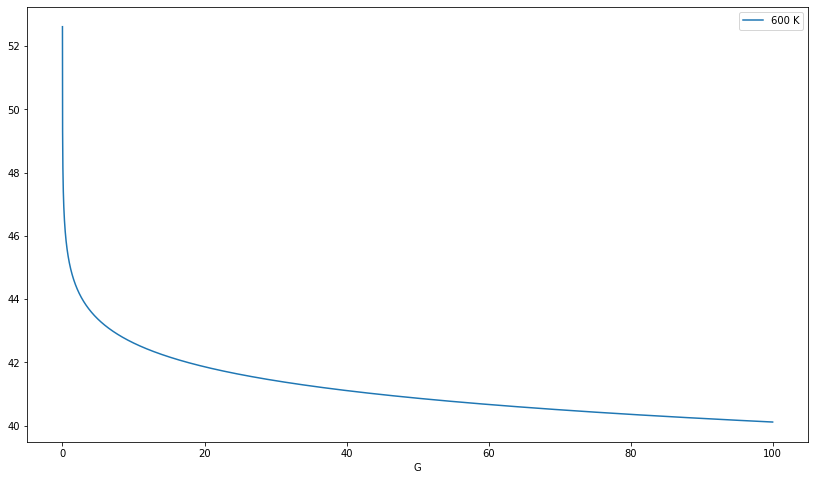

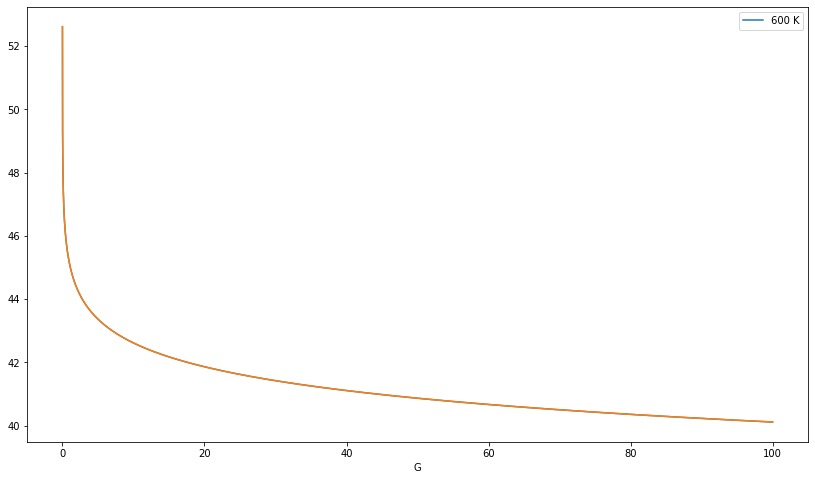

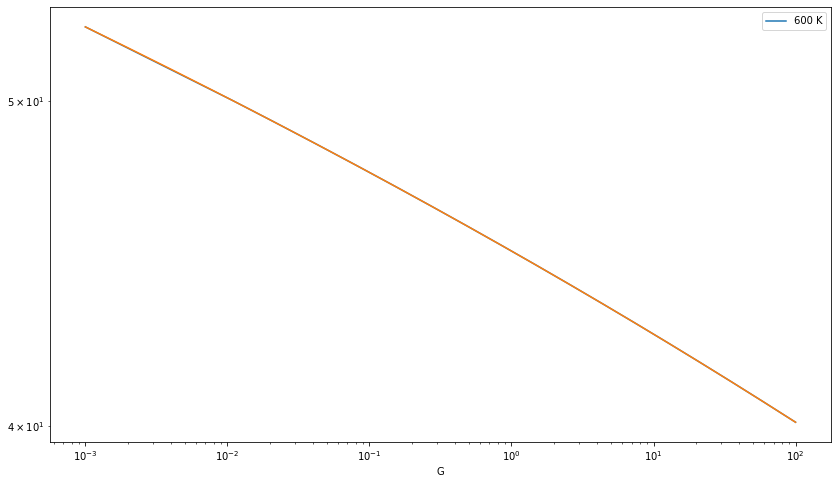

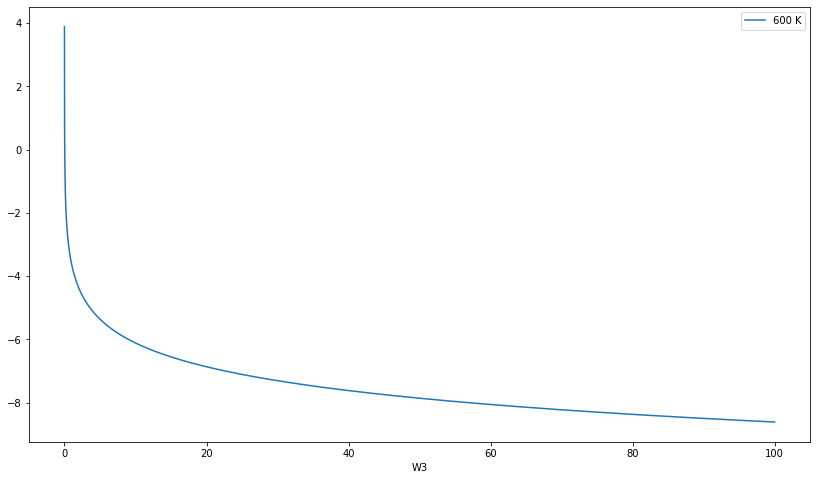

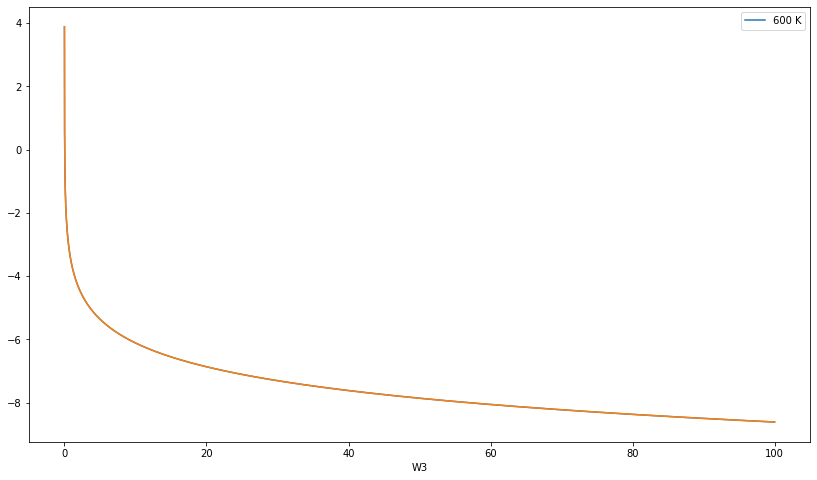

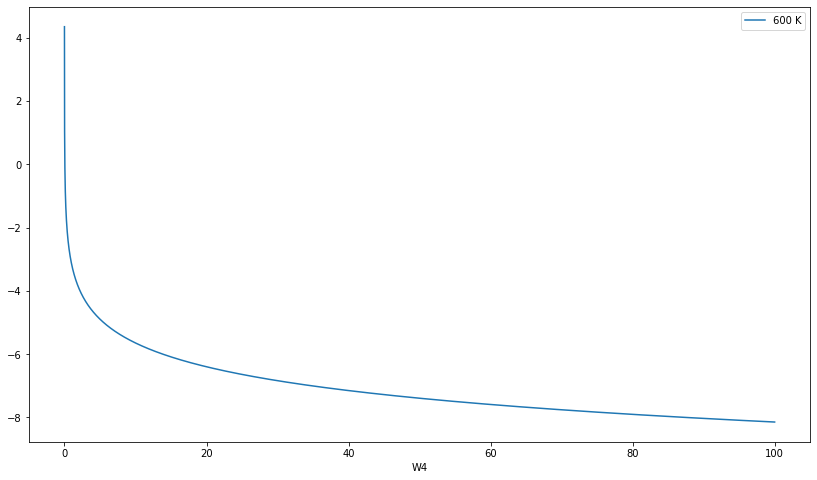

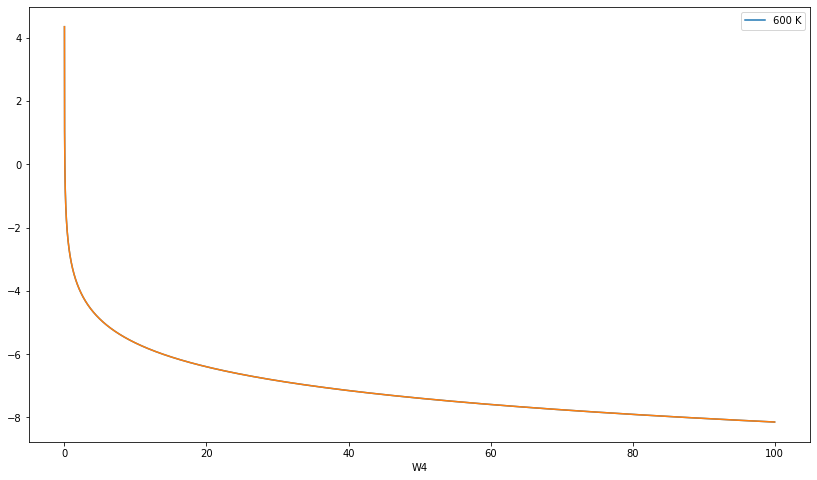

In [37]:
x = np.arange(0.001,100,0.001)

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt1[0],popt1[1],popt1[2],popt1[3],popt1[4])))
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,GG,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt1[0],popt1[1],popt1[2],popt1[3],popt1[4])))
plt.xlabel(r'Lbol')
plt.xlabel(r'G')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW3,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'W3')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW3,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt2[0],popt2[1],popt2[2],popt2[3],popt2[4]))-50)
plt.xlabel(r'Lbol')
plt.xlabel(r'W3')
plt.legend()
plt.show()


plt.figure(figsize=(14,8))
plt.plot(luminosity,WW4,label='600 K')
plt.xlabel(r'Lbol')
plt.xlabel(r'W4')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(14,8))
plt.plot(luminosity,WW4,label='600 K')
plt.plot(x,10**(eqn(np.log10(x),popt3[0],popt3[1],popt3[2],popt3[3],popt3[4]))-50)
plt.xlabel(r'Lbol')
plt.xlabel(r'W4')
plt.legend()
plt.show()

#[-2.49649566e-05 -6.66586021e-04 -2.40679889e-02 -1.05452859e-06 1.65428099e+00]
#[-2.29440595e-05 -6.30431088e-04 -2.34057136e-02 -9.41970700e-07 1.66639928e+00]
#[-2.22563577e-05 -6.17879406e-04 -2.31713853e-02 -9.04408975e-07 1.67076929e+00]

# T = 300
# x = np.log10(luminosity)
# g = np.log10(G)
# g = np.log10(G)
# g(x) = -2.49649566e-05*x**3 + -6.66586021e-04*x**2 + -2.40679889e-02*x + -1.05452859e-06*x**4 + 1.65428099e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.29440595e-05*x**3 + -6.30431088e-04*x**2 + -2.34057136e-02*x + -9.41970700e-07*x**4 + 1.66639928e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.22563577e-05*x**3 + -6.17879406e-04*x**2 + -2.31713853e-02*x + -9.04408975e-07*x**4 + 1.67076929e+00